## Exploring Defences against Data Poisoning and Adversarial Attacks in Machine Learning

# Imports

In [ ]:
#imports
try:
  import secml
except ImportError:
  %pip install secml

try:
  import foolbox
except ImportError:
  %pip install foolbox

from secml.data.loader import CDataLoaderMNIST
from torch import nn
import torch
from secml.ml.classifiers import CClassifierPyTorch
import torch.optim as optim
from secml.ml.peval.metrics import CMetricAccuracy
from secml.figure import CFigure

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.0/464.0 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.4 MB/s eta 0:00:00
2024-11-14 04:13:24,843 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data
2024-11-14 04:13:24,843 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data


INFO:secml.settings:New `SECML_HOME_DIR` created: /root/secml-data


2024-11-14 04:13:24,850 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf
2024-11-14 04:13:24,850 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf


INFO:secml.settings:Default configuration file copied to: /root/secml-data/secml.conf


2024-11-14 04:13:24,856 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets
2024-11-14 04:13:24,856 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets


INFO:secml.settings:New `SECML_DS_DIR` created: /root/secml-data/datasets


2024-11-14 04:13:24,859 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models
2024-11-14 04:13:24,859 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models


INFO:secml.settings:New `SECML_MODELS_DIR` created: /root/secml-data/models


2024-11-14 04:13:24,864 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments
2024-11-14 04:13:24,864 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments


INFO:secml.settings:New `SECML_EXP_DIR` created: /root/secml-data/experiments


2024-11-14 04:13:24,867 - secml.settings - INFO - New `SECML_LOGS_DIR` created: /root/secml-data/logs
2024-11-14 04:13:24,867 - secml.settings - INFO - New `SECML_LOGS_DIR` created: /root/secml-data/logs


INFO:secml.settings:New `SECML_LOGS_DIR` created: /root/secml-data/logs


2024-11-14 04:13:24,871 - secml.settings - INFO - New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data
2024-11-14 04:13:24,871 - secml.settings - INFO - New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data


INFO:secml.settings:New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data


Preprocessing

In [ ]:
n_tr = 30000  # number of training samples
n_ts = 1000 # number of testing samples

loader = CDataLoaderMNIST()
tr = loader.load('training', num_samples=n_tr)
ts = loader.load('testing', num_samples=n_ts)

# normalize the data
tr.X = tr.X / 255
ts.X = ts.X / 255


File stored in `/root/secml-data/datasets/mnist/train-images-idx3-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/train-labels-idx1-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/t10k-images-idx3-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/t10k-labels-idx1-ubyte.gz`


## Model

In [ ]:
class Net(nn.Module):
  #dataset for a MNIST 10 classes
  def __init__(self): #specifices the architecture
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1,10,kernel_size = 5)
    self.conv2 = nn.Conv2d(10,20,kernel_size = 5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320,50)
    self.fc2 = nn.Linear(50,10)

  def forward(self,x): #passes input through all the defined layers with activation functions
    x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
    x = torch.relu(torch.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1,320)
    x = torch.relu(self.fc1(x))
    return self.fc2(x)


net = Net() #make the neural  network
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)
loss_function = nn.CrossEntropyLoss()

#classifier
clf = CClassifierPyTorch(model = net,
                        loss= loss_function,
                        optimizer= optimizer,
                        epochs = 3,
                        batch_size = 20,
                        input_shape = (1, 28,28),
                        random_state =0)

clf.fit(tr.X, tr.Y) #training



Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
#original dataset test
metric = CMetricAccuracy()
preds = clf.predict(ts.X)
accuracy = metric.performance_score(y_true=ts.Y, y_pred=preds)
print(f"Accuracy on entire test set: {accuracy * 100}%")

Accuracy on entire test set: 83.7%


In [ ]:
#training data original
metric = CMetricAccuracy()
preds = clf.predict(tr.X)
accuracy = metric.performance_score(y_true=tr.Y, y_pred=preds)
print(f"Accuracy on entire training set: {accuracy * 100}%")

Accuracy on entire test set: 84.78666666666666%


Not overfitted or underfitted!

## Data Poisoning Attack

In [ ]:
from secml.adv.attacks.evasion import CFoolboxPGDLinf
y_target = None
lb, ub = 0.0, 1.0
eps = 0.2
rel_stepsize = 0.025
steps = 50
samples = ts #samples

#PGD attack
attack = CFoolboxPGDLinf(clf, y_target,
                         lb=lb, ub=ub,
                         epsilons=eps,
                         rel_stepsize=rel_stepsize,
                         steps=steps,
                         random_start=False)

y_pred, _, adv_ds_PGD, _ = attack.run(samples.X, samples.Y) #the attack


In [ ]:
adv_ds_PGD.X # these are the adversarial samples

CArray(1000, 784)(dense: [[0.    0.    0.16  ... 0.    0.025 0.135] [0.2   0.18  0.    ... 0.    0.    0.   ] [0.    0.095 0.09  ... 0.01  0.01  0.01 ] ... [0.045 0.115 0.135 ... 0.    0.    0.   ] [0.    0.    0.2   ... 0.2   0.    0.   ] [0.    0.    0.    ... 0.195 0.085 0.01 ]])

In [ ]:
y_pred #predictions

CArray(1000,)(dense: [2 5 8 ... 5 5 5])

In [ ]:
adv_ds_PGD.Y # these are the true labels

CArray(1000,)(dense: [7 2 1 ... 0 0 0])

In [ ]:
#combine the samples and labels and add it to the copy of the trainig set

In [ ]:
import numpy as np
import copy

In [ ]:
tr_copy = copy.deepcopy(tr)

In [ ]:
import numpy as np

# Assuming tr_copy and adv_ds_PGD are CDatasets from secml
# 1. Convert to NumPy arrays (if necessary)
tr_copy_X_np = tr_copy.X.tondarray()
tr_copy_Y_np = tr_copy.Y.tondarray()
adv_ds_PGD_X_np = adv_ds_PGD.X.tondarray()
y_pred_np = y_pred.tondarray() # Need the wrong labels

# 2. Stack the data and labels
combined_X = np.vstack((tr_copy_X_np, adv_ds_PGD_X_np))
combined_Y = np.concatenate((tr_copy_Y_np, y_pred_np))

# 3. Create a new CDataset instead of updating tr_copy
# This ensures the number of samples and labels are consistent
from secml.data import CDataset
tr_copy_combined = CDataset(combined_X, combined_Y)

# Now tr_copy_combined contains both original and adversarial data

In [ ]:
tr_copy_combined #poisoned dataset

CDataset{'X': CArray(31000, 784)(dense: [[0.    0.    0.    ... 0.    0.    0.   ] [0.    0.    0.    ... 0.    0.    0.   ] [0.    0.    0.    ... 0.    0.    0.   ] ... [0.    0.    0.01  ... 0.    0.2   0.13 ] [0.    0.04  0.    ... 0.    0.085 0.   ] [0.03  0.01  0.06  ... 0.2   0.2   0.2  ]]), 'Y': CArray(31000,)(dense: [5 0 4 ... 5 0 5]), 'header': None}

##  Adversarial Examples Defending

In [ ]:
clf_poisoned = CClassifierPyTorch(model = net,
                        loss= loss_function,
                        optimizer= optimizer,
                        epochs = 3,
                        batch_size = 20,
                        input_shape = (1, 28,28),
                        random_state =0)
# for training use the same split of training 30k training samples
clf_poisoned.fit(tr_copy_combined[:30000,:].X, tr_copy_combined[:30000,:].Y) #training

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
#clean dataset
metric = CMetricAccuracy()
clean_preds = clf_poisoned.predict(ts.X)
accuracy = metric.performance_score(y_true=ts.Y, y_pred=clean_preds)
print(f"Accuracy on clean data set: {accuracy * 100}%")

Accuracy on clean data set: 96.89999999999999%


In [ ]:
#poinsed daata set
metric = CMetricAccuracy()
#use the last 1k as testing samples
poisoned_preds = clf_poisoned.predict(tr_copy_combined[-1000:,:].X)
accuracy = metric.performance_score(y_true=tr_copy_combined[-1000:,:].Y, y_pred=poisoned_preds)
print(f"Accuracy on posoined data set: {accuracy * 100}%")

Accuracy on posoined data set: 58.099999999999994%


## Evaluate

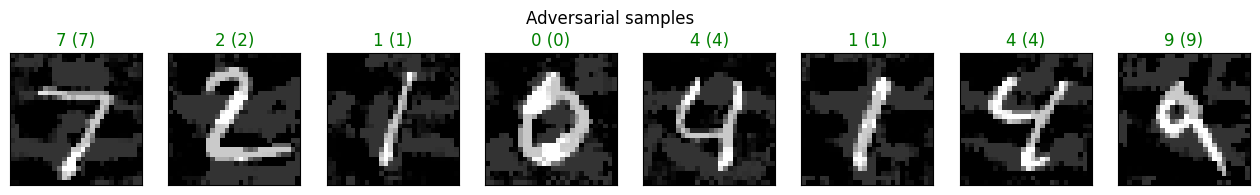

In [ ]:
#genrate and visualize adversarial examples
def show_digits(samples, preds, labels, n_display=8, title=None):
    digits = list(range(10))
    samples = samples.atleast_2d()
    n_display = min(n_display, samples.shape[0])
    fig = CFigure(width=n_display * 2, height=4)
    for idx in range(n_display):
        fig.subplot(2, n_display, idx + 1)
        fig.sp.xticks([])
        fig.sp.yticks([])
        fig.sp.imshow(samples[idx, :].reshape((28, 28)), cmap='gray')
        fig.sp.title("{} ({})".format(digits[labels[idx].item()], digits[preds[idx].item()]),
                     color=("green" if labels[idx].item() == preds[idx].item() else "red"))
    if title is not None:
        fig.title(title)
    fig.show()

show_digits(samples=adv_ds_PGD.X, preds=adv_ds_PGD.Y, labels=adv_ds_PGD.Y, title="Adversarial samples")

In [ ]:
# sec eval on the robust model
from secml.adv.seceval import CSecEval
from secml.array import CArray

robust_attack = CFoolboxPGDLinf(clf_poisoned, y_target,
                         lb=lb, ub=ub,
                         epsilons=eps,
                         rel_stepsize=rel_stepsize,
                         steps=steps,
                         random_start=False)

epsilon_vals = CArray.linspace(0, stop=0.5, num=10)
sec_eval = CSecEval(attack=robust_attack, param_name="epsilon",param_values=epsilon_vals)
sec_eval.run_sec_eval(ts[:20,:]) #using 20 samples of test set so it goes by faster

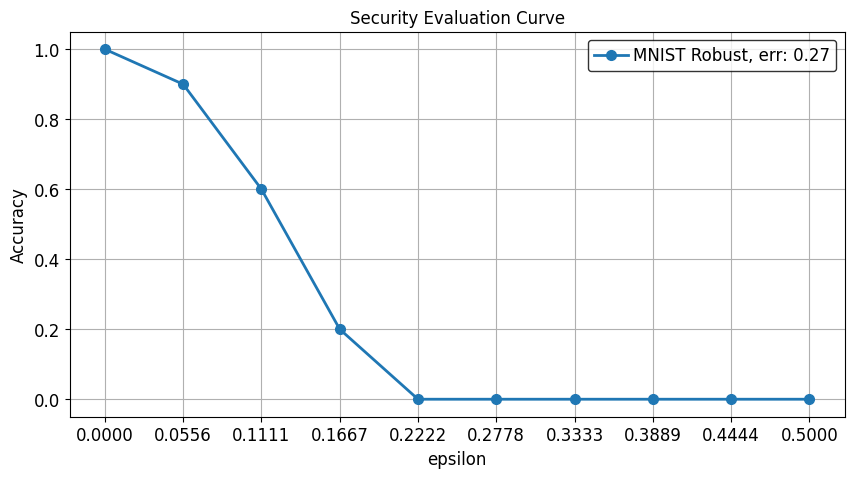

In [ ]:
%matplotlib inline
from secml.figure import CFigure
fig = CFigure(height=5, width=10)
fig.sp.plot_sec_eval(sec_eval.sec_eval_data, marker='o', label="MNIST Robust", show_average=True)
fig.show()

In [ ]:
# create a new attack, generate adversatial examples from that and evaluate it on the clf_poisoned
from secml.adv.attacks.evasion import CFoolboxFGM
y_target = None # untarget
index = 0
point = ts[index, :]
x0, y0 = point.X, point.Y
lb, ub = 0.0, 1.0
eps = 0.1 #epsilon

attack_FGSM = CFoolboxFGM(clf_poisoned, y_target,
                         lb=lb, ub=ub,
                         epsilons=eps,
                         distance='l2',
                         random_start=False)
y_pred, _, adv_ds_fgm, _ = attack.run(ts.X, ts.Y) #the attack on clean dataset


In [ ]:
# use the posioned model and test it on the clean dataste
metric = CMetricAccuracy()
preds = clf_poisoned.predict(ts.X)
accuracy = metric.performance_score(y_true=ts.Y, y_pred=preds)
print(f"Accuracy on robust model using clena data set: {accuracy * 100}%")

Accuracy on robust model using clena data set: 98.2%


In [ ]:
# FGSM adversarial examples on poisoned classifier
metric = CMetricAccuracy()
preds = clf_poisoned.predict(adv_ds_fgm.X)
accuracy = metric.performance_score(y_true=adv_ds_fgm.Y, y_pred=preds)
print(f"Accuracy on robust model using poisoned data set: {accuracy * 100}%")

Accuracy on robust model using poisoned data set: 6.6000000000000005%


## Outlier Dectection

In [ ]:
from sklearn.ensemble import IsolationForest
from secml.data import CDataset
#cleaning on the poisoned dataset
# Create and fit Isolation Forest
outlier_detector = IsolationForest(contamination='auto')  # Or specify a contamination fraction
outlier_detector.fit(tr_copy_combined.X.tondarray())

# Predict outliers and get inlier indices
inlier_indices = outlier_detector.predict(tr_copy_combined.X.tondarray()) == 1

# Create sanitized dataset
sanitized_X = tr_copy_combined.X.todense().tondarray()[inlier_indices, :]
sanitized_Y = tr_copy_combined.Y.tondarray()[inlier_indices]

sanitized_tr_data = CDataset(sanitized_X, sanitized_Y)

In [ ]:
# training data went down from 31000 to 29467 indicating that the outliers where remover
sanitized_tr_data.X.shape

(29467, 784)

In [ ]:
clf_sanitized = CClassifierPyTorch(model = net,
                        loss= loss_function,
                        optimizer= optimizer,
                        epochs = 3,
                        batch_size = 20,
                        input_shape = (1, 28,28),
                        random_state =0)

In [ ]:
clf_sanitized.fit(sanitized_tr_data.X, sanitized_tr_data.Y) #training on sanitized data

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## Evaluate Defenses

In [ ]:
#evaluate accuracy of model with defense mechnisms on clean, poisoned and adversarial
#clean dataset
metric = CMetricAccuracy()
preds = clf_sanitized.predict(ts.X)
accuracy = metric.performance_score(y_true=ts.Y, y_pred=preds)
print(f"Accuracy on clean data set on the : {accuracy * 100}%")

Accuracy on clean data set on the : 98.5%


In [ ]:
#poisoned dataset on model with defense
metric = CMetricAccuracy()
preds = clf_sanitized.predict(tr_copy_combined[-1000:,:].X)
accuracy = metric.performance_score(y_true=tr_copy_combined[-1000:,:].Y, y_pred=preds)
print(f"Accuracy on poisoned data set: {accuracy * 100}%")

Accuracy on poisoned data set: 58.099999999999994%


In [ ]:
#adversarial datset of model with defense
metric = CMetricAccuracy()
preds = clf_sanitized.predict(adv_ds_fgm.X)
accuracy = metric.performance_score(y_true=adv_ds_fgm.Y, y_pred=preds) #FGM attack from phase 5
print(f"Accuracy on adversarial data set: {accuracy * 100}%")

Accuracy on adversarial data set: 9.6%
